In [1]:
import scipy.io.wavfile
import glob
import pretty_midi
import os
import IPython.display as ipd 
import librosa
import time
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy

In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
midi_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.mid'))
sf2_path = "/usr/share/sounds/sf2/FluidR3_GM.sf2"

num = 0
start = time.time()

midi_file = "/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.mid"
fs = 44100

pm = pretty_midi.PrettyMIDI(midi_file=midi_file)
start = time.time()
pm_samples = pm.fluidsynth(fs=fs, sf2_path=sf2_path)
print("wav gen {}s".format(time.time()-start))
start = time.time()
print("pm_samples {}".format(len(pm_samples)))
print("end time {}s".format(pm.get_end_time()))

wav gen 8.075520515441895s
pm_samples 13841569
end time 312.86777125000003s


In [3]:
pm_iso = pretty_midi.PrettyMIDI()
print(pm.instruments[0].notes[1])
pm_iso.instruments = [pm.instruments[0]]
print(pm_iso.instruments)
pm_iso.instruments[0].notes = [pm_iso.instruments[0].notes[1]]
print(pm_iso.instruments[0].notes)
note_start = pm_iso.instruments[0].notes[0].start
note_end = pm_iso.instruments[0].notes[0].end
note_pitch = pm_iso.instruments[0].notes[0].pitch
note_velocity = pm_iso.instruments[0].notes[0].velocity
print("velocity {}".format(note_velocity))
note_iso_duration = note_end - note_start
print("duration {}s".format(note_iso_duration))
print(pm_iso.instruments[0].notes[0].end)
pm_iso.instruments[0].notes[0].end = note_iso_duration
print(pm_iso.instruments[0].notes[0].end)
pm_iso.instruments[0].notes[0].start = 0.0
pm_iso.instruments[0].notes[0].velocity = note_velocity

start = time.time()
pm_iso_samples = pm_iso.fluidsynth(fs=fs, sf2_path=sf2_path)
print("wav gen {}s".format(time.time()-start))
print("pm_iso_samples {}".format(len(pm_iso_samples)))
print(pm_iso.instruments[0].notes)

Note(start=51.484787, end=51.758593, pitch=81, velocity=105)
[Instrument(program=0, is_drum=False, name="A.PIANO 1")]
[Note(start=51.484787, end=51.758593, pitch=81, velocity=105)]
velocity 105
duration 0.2738054166666686s
51.75859270833333
0.2738054166666686
wav gen 2.1436119079589844s
pm_iso_samples 13738408
[Note(start=0.000000, end=0.273805, pitch=81, velocity=105)]


In [4]:
# cut out irrelevant sections
sample_duration = int(note_start - note_end)
sample_start = int(note_start * 44100)
sample_end = sample_start + sample_duration

pm_iso_samples = pm_iso_samples[:sample_duration+44100]
pm_samples = pm_samples[sample_start:sample_end+44100]

In [5]:
ipd.Audio(data=pm_samples, rate=44100)

<function matplotlib.pyplot.show(*args, **kw)>

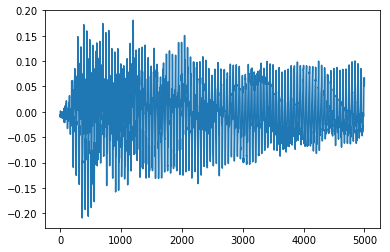

In [25]:
plt.plot(pm_samples[:5000])
plt.show

In [7]:
ipd.Audio(data=pm_iso_samples, rate=44100)

<function matplotlib.pyplot.show(*args, **kw)>

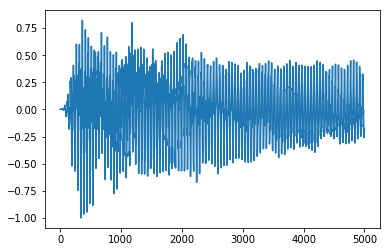

In [26]:
plt.plot(pm_iso_samples[:5000])
plt.show
# are the relative audio levels affected by synthesizing alone?
# or is this just pitch being more accurate and less averaged

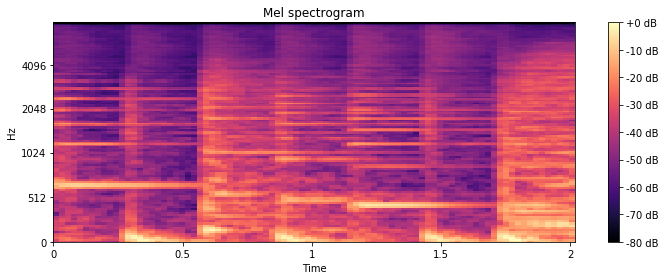

In [9]:
# make the spectrograms
spec_og = librosa.feature.melspectrogram(y=pm_samples, sr=44100)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spec_og, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

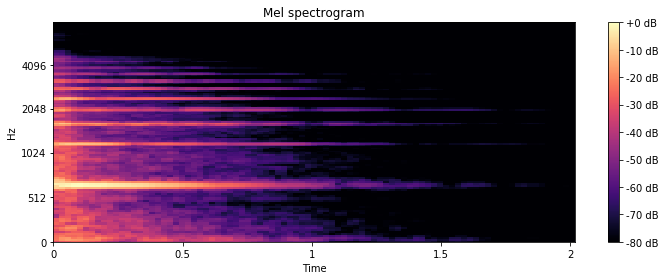

In [10]:
spec_iso = librosa.feature.melspectrogram(y=pm_iso_samples, sr=44100)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spec_iso, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# why does the note look relatively louder?

(128, 87)
(128, 87)


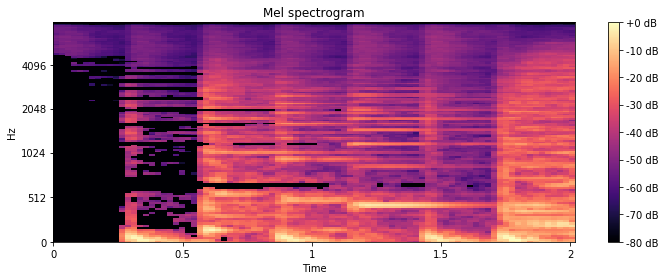

In [11]:
print(spec_og.shape)
print(spec_iso.shape)
spec_diff = spec_og - spec_iso
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spec_diff, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

# how can we convert this back to audio once we have found the mask?
# should the mask predict binary values?

81


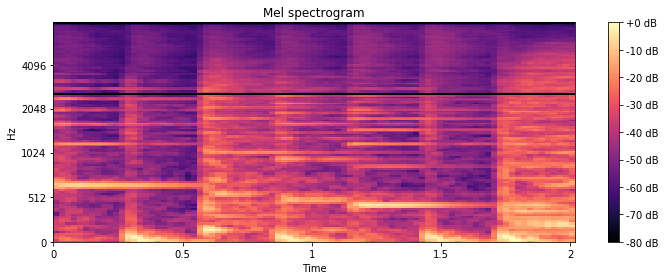

In [12]:
print(note_pitch)  # 81, A5, 880ish
note_hz = pretty_midi.note_number_to_hz(note_pitch)
spec_indicator = spec_og
spec_indicator[note_pitch,:] = 0
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spec_indicator, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [13]:

# at the end, we have relative note onset / offset, audio w background, audio iso 
# still need to generate mask
# split this code into manageable chunks

(1025, 87)


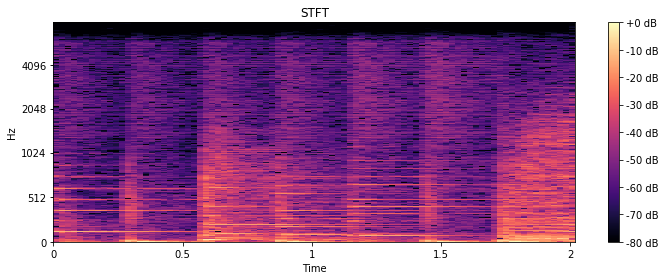

In [14]:
og_stft = librosa.core.stft(y=pm_samples)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(og_stft**2), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT')
plt.tight_layout()
print(og_stft.shape)

In [15]:
new_pm_samples = librosa.core.istft(stft_matrix=og_stft)
ipd.Audio(data=new_pm_samples, rate=44100)

In [16]:
def normalize(a):
    a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
    return a_oo/np.abs(a_oo).max()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

(-3.1977816+0j)
(-170.37001-49.813953j)
(-185.22491455078125-83.31867980957031j)
(-3.1977816+0j)
(185.22491+83.31868j)
(1025, 87)
203.10162
82.20781


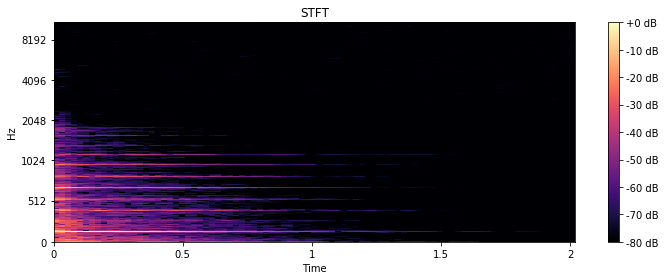

In [17]:
iso_stft = librosa.core.stft(y=pm_iso_samples)
print(iso_stft[0][0])
print(np.min(iso_stft))
print(-1 * np.max(iso_stft))
print(iso_stft[0][0])
print(np.max(iso_stft))
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft**2), ref=np.max), 
                         y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT')
plt.tight_layout()
print(iso_stft.shape)

print(np.max(np.abs(iso_stft)))
print(np.max(np.abs(og_stft)))

(0.32761207-0j)
134295.64
(52097.168-36866.656j)
(0.5416903+0.053963296j)
(0.6156531+0j)
(1025, 87)


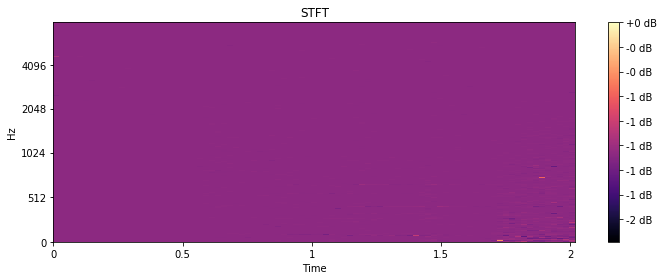

In [18]:
stft_diff = og_stft / iso_stft
print(stft_diff[0][0])
print(np.max(np.abs(stft_diff)))
print(np.max(stft_diff))
stft_diff = sigmoid(normalize((og_stft / iso_stft)))
print(stft_diff[0][0])
print(np.max(stft_diff))
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(stft_diff**2), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT')
plt.tight_layout()
print(stft_diff.shape)

In [19]:
diff_samples = librosa.core.istft(stft_matrix=stft_diff)
ipd.Audio(data=diff_samples, rate=44100)

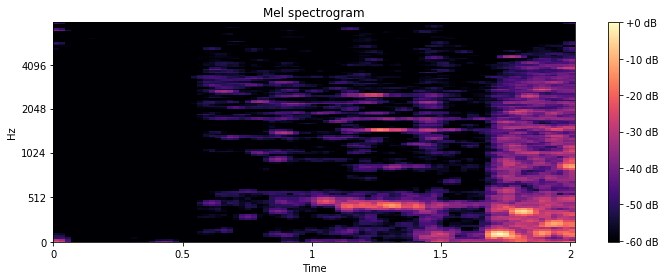

In [20]:
spec_diff = librosa.feature.melspectrogram(y=diff_samples, sr=44100)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spec_diff, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

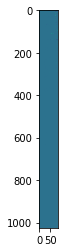

In [21]:
plt.imshow(np.abs(stft_diff))
plt.show()


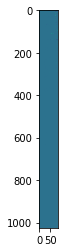

In [22]:
plt.imshow(np.abs(stft_diff), interpolation='nearest')
plt.show()